Import Library

In [320]:
# Install Library yang dibutuhkan
#%pip install TA-Lib
#%pip install bayesian-optimization

In [321]:
# Library
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings ('ignore')

# Grafik dan Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Indikator Teknikal Saham
import talib

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

plt.rcParams['font.size'] = 13

Pengumpulan dan Input Data

In [322]:
# Memasukkan Data Olahan
path_data = r"D:\file\[KULIAHAN]\SKRIPSI\Resources\Data Olahan\BBCA_01102019_01102025.xlsx"
data = pd.read_excel(path_data, parse_dates=['Date'], index_col='Date')

# Melihat 10 Sampel Data Teratas
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2019-10-01,5212.767129,5260.471321,5212.767129,5238.787598,40057000.0
2019-10-02,5212.767466,5264.808406,5212.767466,5247.461426,52376500.0
2019-10-03,5212.767129,5243.124342,5160.726193,5238.787598,50269000.0
2019-10-04,5186.746829,5260.471491,5186.746829,5243.124512,56890500.0
2019-10-07,5264.808105,5273.481595,5247.461127,5264.808105,56705500.0
2019-10-08,5273.481634,5290.828613,5217.103952,5290.828613,46997500.0
2019-10-09,5290.828574,5290.828574,5247.461127,5264.808105,41496500.0
2019-10-10,5221.441031,5299.502441,5221.441031,5299.502441,65806500.0
2019-10-11,5273.481990,5338.533166,5273.481990,5312.512695,40863500.0


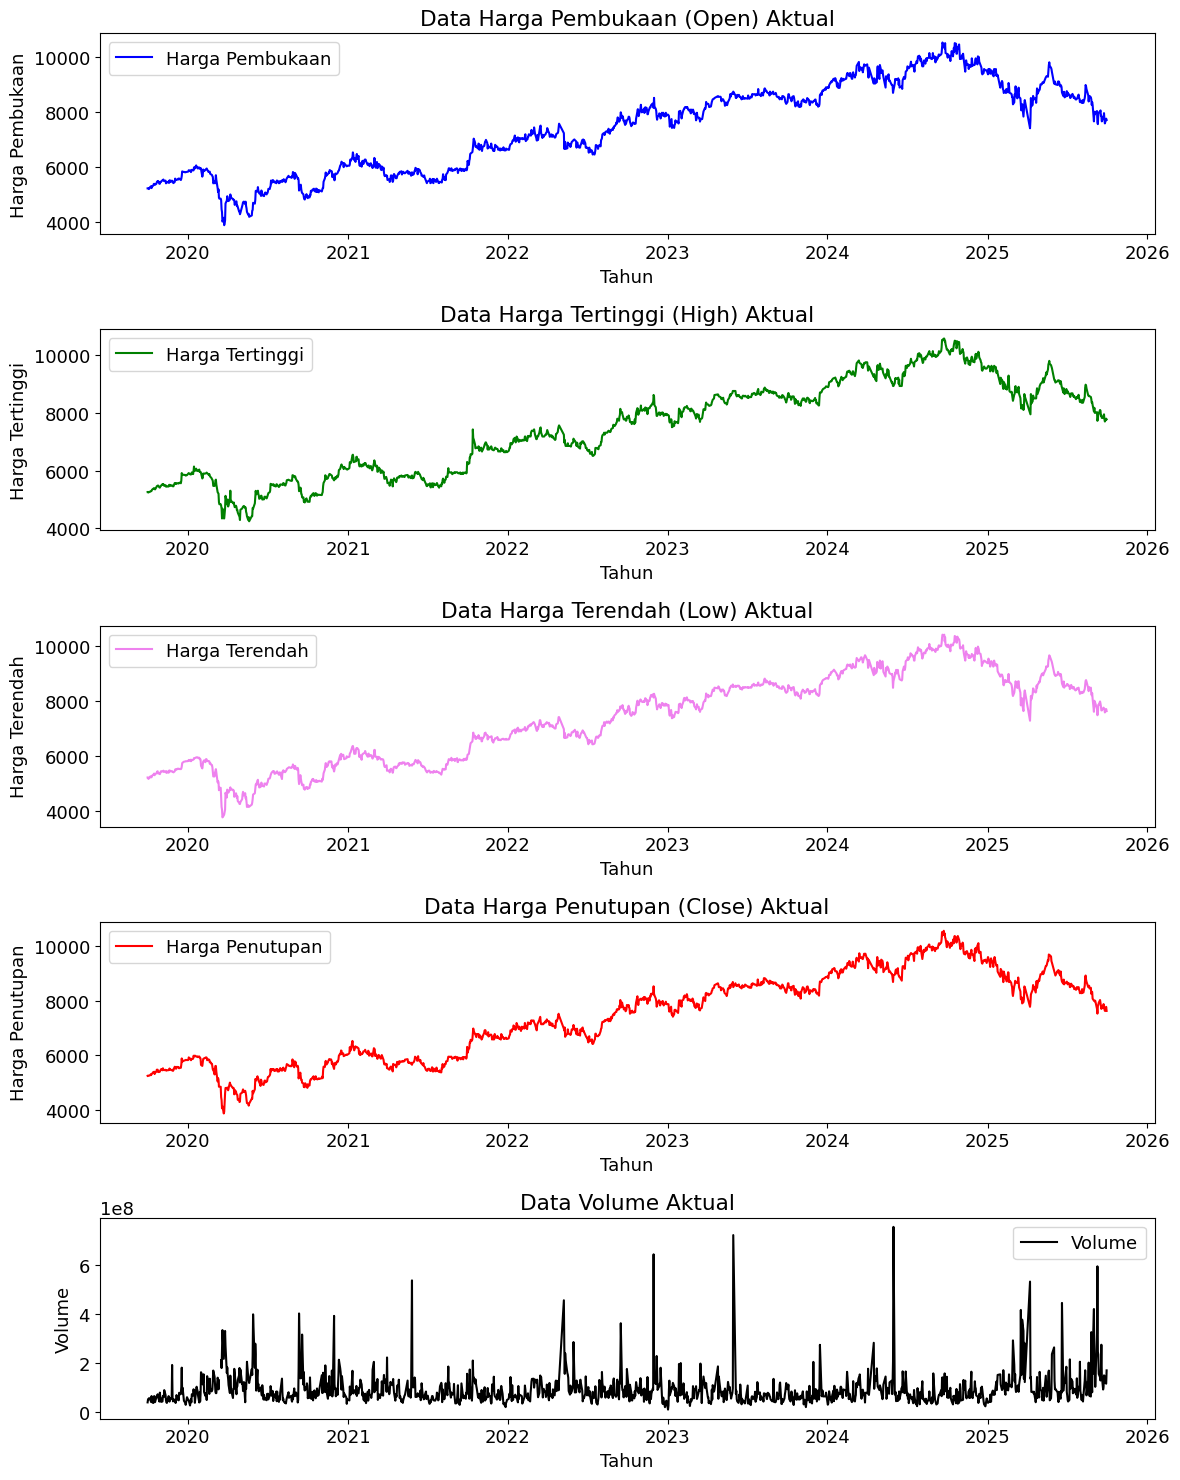

In [323]:
# Melakukan Visualisasi terhadap Masing-Masing Indikator
plt.figure(figsize=(12,15))

# Plotting Data dari Indikator 'Open'
plt.subplot(511)
plt.plot(data['Open'], label='Harga Pembukaan', color='blue')
plt.title('Data Harga Pembukaan (Open) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Pembukaan')
plt.legend()

# Plotting Data dari Indikator 'High'
plt.subplot(512)
plt.plot(data['High'], label='Harga Tertinggi', color='green')
plt.title('Data Harga Tertinggi (High) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Tertinggi')
plt.legend()

# Plotting Data dari Indikator 'Low'
plt.subplot(513)
plt.plot(data['Low'], label='Harga Terendah', color='violet')
plt.title('Data Harga Terendah (Low) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Terendah')
plt.legend()

# Plotting Data dari Indikator 'Close'
plt.subplot(514)
plt.plot(data['Close'], label='Harga Penutupan', color='red')
plt.title('Data Harga Penutupan (Close) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan')
plt.legend()

# Plotting Data dari Indikator 'Volume'
plt.subplot(515)
plt.plot(data['Volume'], label='Volume', color='black')
plt.title('Data Volume Aktual')
plt.xlabel('Tahun')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()

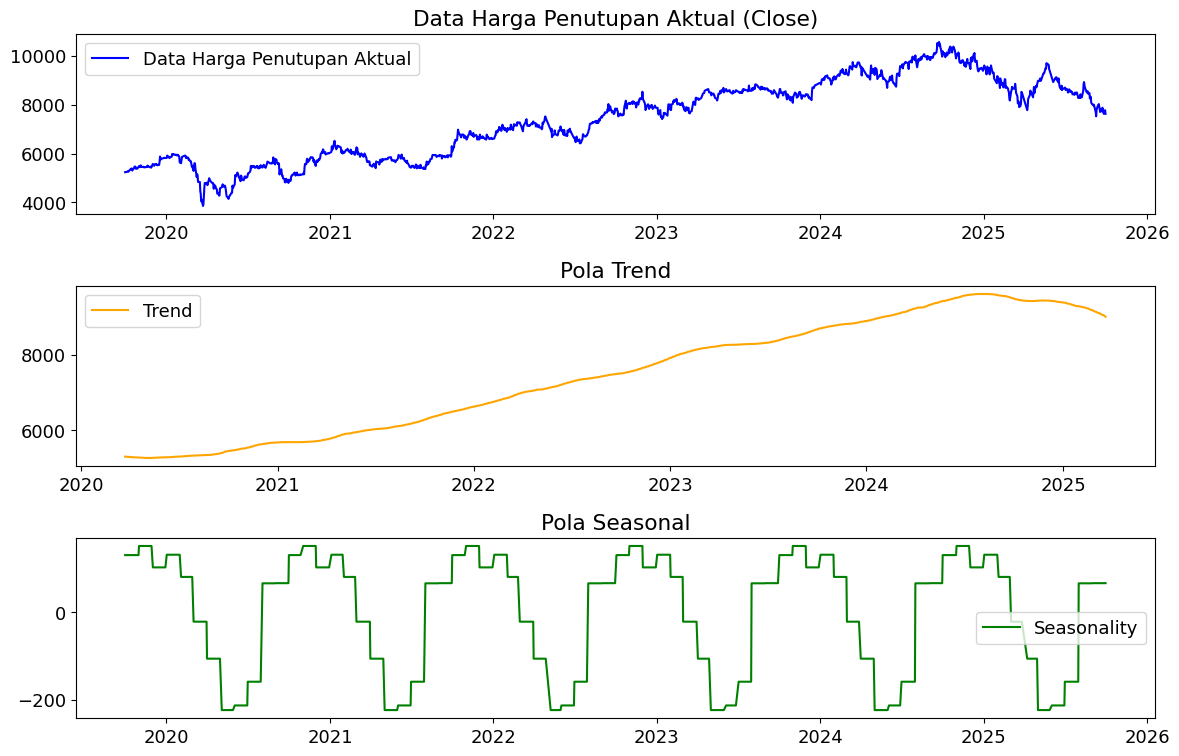

In [324]:
def dekomposisi_data_harian(data, visualisasi=True):
    df= pd.DataFrame(index=data.index)
    
    # Menghitung Moving Average
    df['Trend'] = data['Close'].rolling(window=240, center=True).mean() 
    # Menghitung Detrend
    df['Detrended'] = data['Close'] - df['Trend']
    # Menghitunga Seasonality
    seasonal_indices = df['Detrended'].groupby(data.index.month).mean()
    seasonal_indices = seasonal_indices - np.mean(seasonal_indices) # Seasonality berdistribusi normal
    
    df['Seasonal'] = data.index.month.map(seasonal_indices)
        
    if visualisasi:
        # Melakukan Plotting
        plt.figure(figsize=(12, 10))

        plt.subplot(411)
        plt.plot(data['Close'], label='Data Harga Penutupan Aktual', color='blue')
        plt.title('Data Harga Penutupan Aktual (Close)')
        plt.legend()

        plt.subplot(412)
        plt.plot(df['Trend'], label='Trend', color='orange')
        plt.title('Pola Trend')
        plt.legend()

        plt.subplot(413)
        plt.plot(df['Seasonal'], label='Seasonality', color='green')
        plt.title('Pola Seasonal')
        plt.legend()

        plt.tight_layout()
        
    return df

hasil = dekomposisi_data_harian(data, visualisasi=True)


Data Pre Processing

In [325]:
# Melihat Statistika Deskriptif dari Data Olahan
data.describe()

,Open,High,Low,Close,Volume
count,1447.000000,1447.000000,1447.000000,1447.000000,1.445000e+03
mean,7383.426806,7450.409705,7314.766545,7380.667236,9.154095e+07
std,1588.747447,1595.192289,1585.484966,1590.319202,6.241176e+07
min,3871.916705,4248.649167,3763.156040,3854.514893,1.065390e+07
25%,5855.645264,5899.235262,5809.532638,5853.435547,5.741600e+07
50%,7543.362443,7658.003210,7497.505793,7566.290039,7.705510e+07
75%,8637.069754,8686.766916,8562.326521,8625.000000,1.058940e+08
max,10522.147296,10570.414062,10401.480469,10570.414062,7.564316e+08


In [326]:
# Melihat informasi umum dari data olahan
data.info()

# Cek Missing Value pada Data Olahan
data.isnull()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2019-10-01 to 2025-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1447 non-null   float64
 1   High    1447 non-null   float64
 2   Low     1447 non-null   float64
 3   Close   1447 non-null   float64
 4   Volume  1445 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB
Open      0
High      0
Low       0
Close     0
Volume    2
dtype: int64


In [327]:
# Mengisi NaN di 'Volume' dengan nilai 'Volume' terakhir yang valid
data['Volume'].fillna(method='ffill', inplace=True)

# Melihat informasi umum dari data olahan setelah dilakukan penanganan missing value
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2019-10-01 to 2025-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1447 non-null   float64
 1   High    1447 non-null   float64
 2   Low     1447 non-null   float64
 3   Close   1447 non-null   float64
 4   Volume  1447 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB


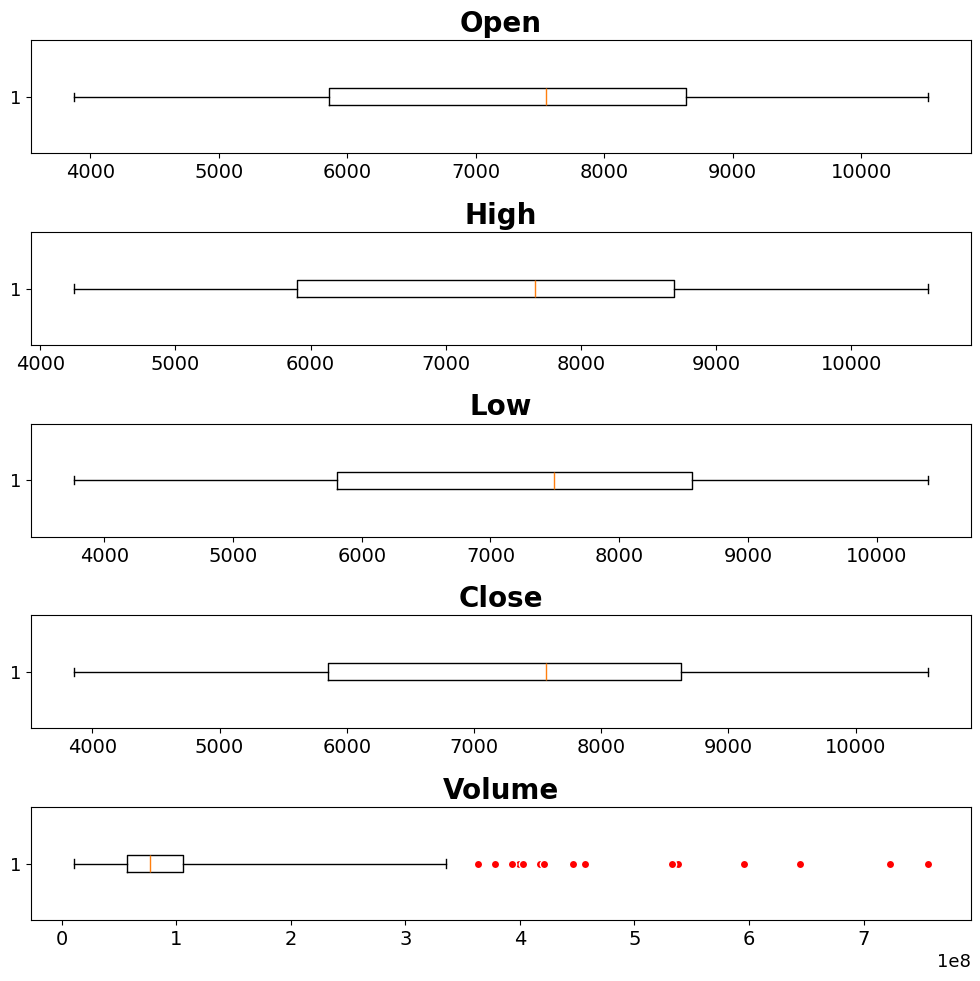

In [328]:
# Melihat distribusi sampel data dari Variabel OHLCV
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(len(data.columns), 1,  figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data.iloc[:,i], flierprops=red_circle, vert = False, whis=5)
    ax.set_title(data.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()

In [329]:
target_data = data['Volume']

# Setelan whisker multiplier
whis_multiplier = 5.0

# Menghitung Q1, Q3, dan IQR
Q1 = target_data.quantile(0.25)
Q3 = target_data.quantile(0.75)
IQR = Q3 - Q1

# Menghitung batas atas dan bawah
upper_boundary = Q3 + (whis_multiplier * IQR)
lower_boundary = Q1 - (whis_multiplier * IQR)

# Mengidentifikasi outlier
outliers = target_data[(target_data > upper_boundary) | (target_data < lower_boundary)]
        
# Mencetak hasil perhitungan
print(f"--- Perhitungan Outlier untuk '{column_name}' (whis={whis_multiplier}) ---")
print(f"Q1 (Persentil 25): {Q1:,.2f}")
print(f"Q3 (Persentil 75): {Q3:,.2f}")
print(f"IQR (Q3 - Q1): {IQR:,.2f}")
print(f"--------------------------------------------------")
print(f"Batas Bawah (Q1 - {whis_multiplier}*IQR): {lower_boundary:,.2f}")
print(f"Batas Atas (Q3 + {whis_multiplier}*IQR): {upper_boundary:,.2f}")
print(f"--------------------------------------------------")

# Mencetak outlier yang ditemukan
print(f"Terdapat {len(outliers)} outlier pada variabel '{column_name}':")
# Menggunakan .to_string() untuk memastikan semua baris tercetak
print(outliers.to_string())

--- Perhitungan Outlier untuk 'Volume' (whis=5.0) ---
Q1 (Persentil 25): 57,417,950.00
Q3 (Persentil 75): 106,083,100.00
IQR (Q3 - Q1): 48,665,150.00
--------------------------------------------------
Batas Bawah (Q1 - 5.0*IQR): -185,907,800.00
Batas Atas (Q3 + 5.0*IQR): 349,408,850.00
--------------------------------------------------
Terdapat 15 outlier pada variabel 'Volume':
Date
2020-05-29    399414000.0
2020-09-11    403032500.0
2020-11-30    393091500.0
2021-05-27    537971500.0
2022-05-09    456796600.0
2022-09-16    363127600.0
2022-11-30    644359600.0
2023-05-31    722827900.0
2024-05-31    756431600.0
2025-03-18    417305700.0
2025-03-21    377916400.0
2025-04-08    533073600.0
2025-06-20    445915100.0
2025-09-01    421127500.0
2025-09-09    595368700.0


Skewness Volume Awal: 4.34
Skewness Volume (Log): 0.63


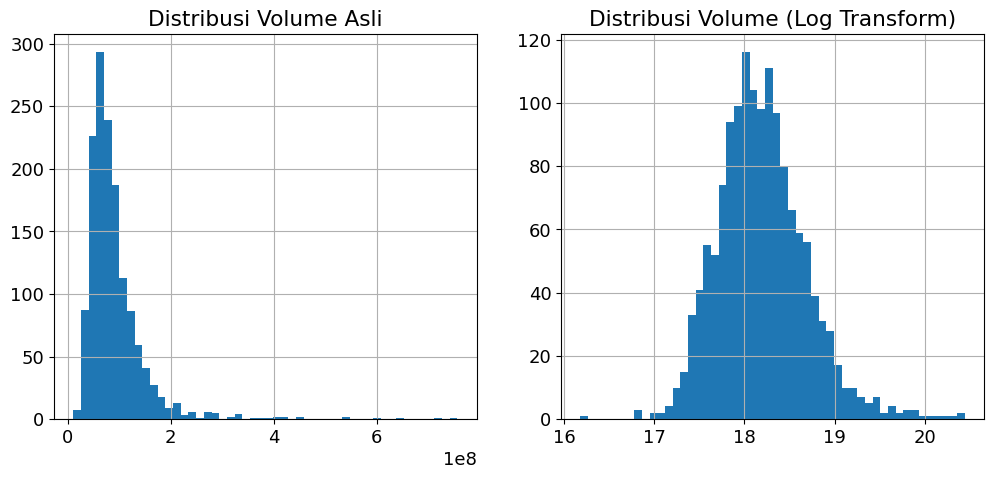

In [330]:
# Cek kemiringan 'Volume' sebelum transformasi
print(f"Skewness Volume Awal: {data['Volume'].skew():.2f}")

# Terapkan Log Transform 
data['Volume_Log'] = np.log1p(data['Volume']) # log1p untuk menghindari error jika ada volume 0

# Cek kemiringan setelah transformasi
print(f"Skewness Volume (Log): {data['Volume_Log'].skew():.2f}")

# Visualisasi perbedaannya
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
data['Volume'].hist(bins=50)
plt.title('Distribusi Volume Asli')

plt.subplot(1, 2, 2)
data['Volume_Log'].hist(bins=50)
plt.title('Distribusi Volume (Log Transform)')
plt.show()

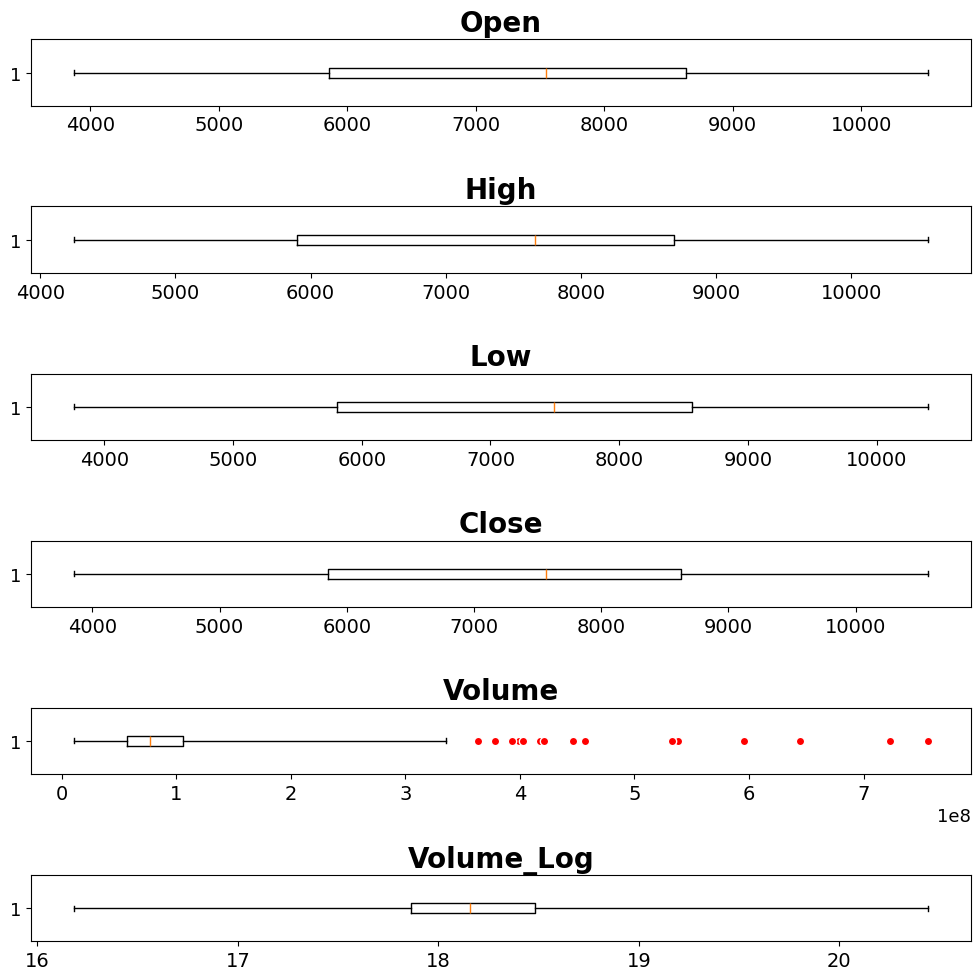

In [331]:
# Melihat distribusi sampel data dari Variabel OHLCV dan 'Volume_Log'
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(len(data.columns), 1,  figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data.iloc[:,i], flierprops=red_circle, vert = False, whis=5)
    ax.set_title(data.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()

Feature Engineering

In [ ]:
# Membentuk variabel lag
def create_lagged_features(data):
    data['Close_Diff'] = data['Close'].diff(1)
    data['MOM_10'] = talib.MOM(data['Close'], timeperiod=10)
    data['ROC_10'] = talib.ROC(data['Close'], timeperiod=10)
    data['Intraday_Range'] = data['High'] - data['Low']
    data['Intraday_Change'] = data['Close'] - data['Open']
    data['ATR_14'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['Volatility_10'] = data['Close_Diff'].rolling(window=10).std()
    
    df_fitur = pd.DataFrame(index=data.index)

    df_fitur['Close'] = data['Close']
    df_fitur['Close_Diff'] = data['Close_Diff']
    
    df_fitur['Open_t-1'] = data['Open'].shift(1)
    df_fitur['High_t-1'] = data['High'].shift(1)
    df_fitur['Low_t-1'] = data['Low'].shift(1)
    df_fitur['Close_t-1'] = data['Close'].shift(1)
    df_fitur['Volume_Log_t-1'] = data['Volume_Log'].shift(1)
    df_fitur['Close_Diff_t-1'] = data['Close_Diff'].shift(1)
        
    df_fitur['MA_5_t-1'] = talib.MA(data['Close'], timeperiod=5).shift(1)
    df_fitur['MA_10_t-1'] = talib.MA(data['Close'], timeperiod=10).shift(1)
    df_fitur['RSI_7_t-1'] = talib.RSI(data['Close'], timeperiod=7).shift(1)
    df_fitur['RSI_14_t-1'] = talib.RSI(data['Close'], timeperiod=14).shift(1)
    df_fitur['MOM_10_t-1'] = data['MOM_10'].shift(1)
    df_fitur['ROC_10_t-1'] = data['ROC_10'].shift(1)
    df_fitur['ATR_14_t-1'] = data['ATR_14'].shift(1)
    df_fitur['Volatility_10_t-1'] = data['Volatility_10'].shift(1)
    df_fitur['Intraday_Range_t-1'] = data['Intraday_Range'].shift(1)
    df_fitur['Intraday_Change_t-1'] = data['Intraday_Change'].shift(1)

    df_fitur['Year'] = df_fitur.index.year
    df_fitur['Month'] = df_fitur.index.month
    df_fitur['Week'] = df_fitur.index.isocalendar().week.astype(float)
    df_fitur['DayOfWeek'] = df_fitur.index.dayofweek
    df_fitur['DayOfMonth'] = df_fitur.index.day
    df_fitur['DayOfYear'] = df_fitur.index.dayofyear
    df_fitur['Quarter'] = df_fitur.index.quarter
    df_fitur['IsMonthStart'] = df_fitur.index.is_month_start.astype(int)
    df_fitur['IsMonthEnd'] = df_fitur.index.is_month_end.astype(int)

    df_fitur.dropna(inplace=True)

    return df_fitur

# Menggabungkan Variabel Tambahan ke dalam Data Olahan
data_keseluruhan = create_lagged_features(data)

# Melihat Informasi Umum Terbaru dari Dara Olahan
data_keseluruhan.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1432 entries, 2019-10-22 to 2025-09-30
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                1432 non-null   float64
 1   Close_Diff           1432 non-null   float64
 2   Open_t-1             1432 non-null   float64
 3   High_t-1             1432 non-null   float64
 4   Low_t-1              1432 non-null   float64
 5   Close_t-1            1432 non-null   float64
 6   Volume_Log_t-1       1432 non-null   float64
 7   Close_Diff_t-1       1432 non-null   float64
 8   MA_5_t-1             1432 non-null   float64
 9   MA_10_t-1            1432 non-null   float64
 10  RSI_7_t-1            1432 non-null   float64
 11  RSI_14_t-1           1432 non-null   float64
 12  MOM_10_t-1           1432 non-null   float64
 13  ROC_10_t-1           1432 non-null   float64
 14  ATR_14_t-1           1432 non-null   float64
 15  Volatility_10_t-1   

Exploratory Data Analysis (EDA)

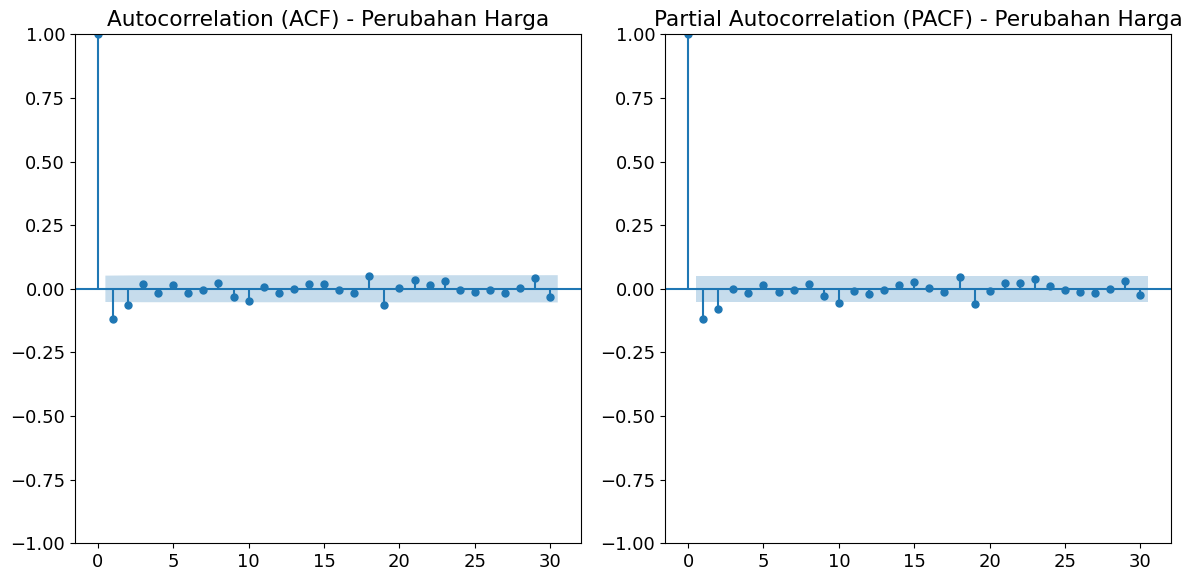

In [333]:
# Melakukan Visualisasi ACF dan PACF dari Variabel 'Close_Diff'
plt.figure(figsize= (12,6))

# Plot ACF dari Variabel 'Close_Diff1'
plt.subplot(121)
plot_acf(data_keseluruhan['Close_Diff'], lags=30, ax=plt.gca(), title= 'Autocorrelation (ACF) - Perubahan Harga')

# Plot PACF dari Variabel 'Close_Diff1'
plt.subplot(122)
plot_pacf(data_keseluruhan['Close_Diff'], lags=30, ax=plt.gca(), title = 'Partial Autocorrelation (PACF) - Perubahan Harga')

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Close_Diff'}>,
        <Axes: title={'center': 'Open_t-1'}>,
        <Axes: title={'center': 'High_t-1'}>,
        <Axes: title={'center': 'Low_t-1'}>],
       [<Axes: title={'center': 'Close_t-1'}>,
        <Axes: title={'center': 'Volume_Log_t-1'}>,
        <Axes: title={'center': 'Close_Diff_t-1'}>,
        <Axes: title={'center': 'MA_5_t-1'}>,
        <Axes: title={'center': 'MA_10_t-1'}>],
       [<Axes: title={'center': 'RSI_7_t-1'}>,
        <Axes: title={'center': 'RSI_14_t-1'}>,
        <Axes: title={'center': 'MOM_10_t-1'}>,
        <Axes: title={'center': 'ROC_10_t-1'}>,
        <Axes: title={'center': 'ATR_14_t-1'}>],
       [<Axes: title={'center': 'Volatility_10_t-1'}>,
        <Axes: title={'center': 'Intraday_Range_t-1'}>,
        <Axes: title={'center': 'Intraday_Change_t-1'}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>],
       [<Axes: title={'center': 

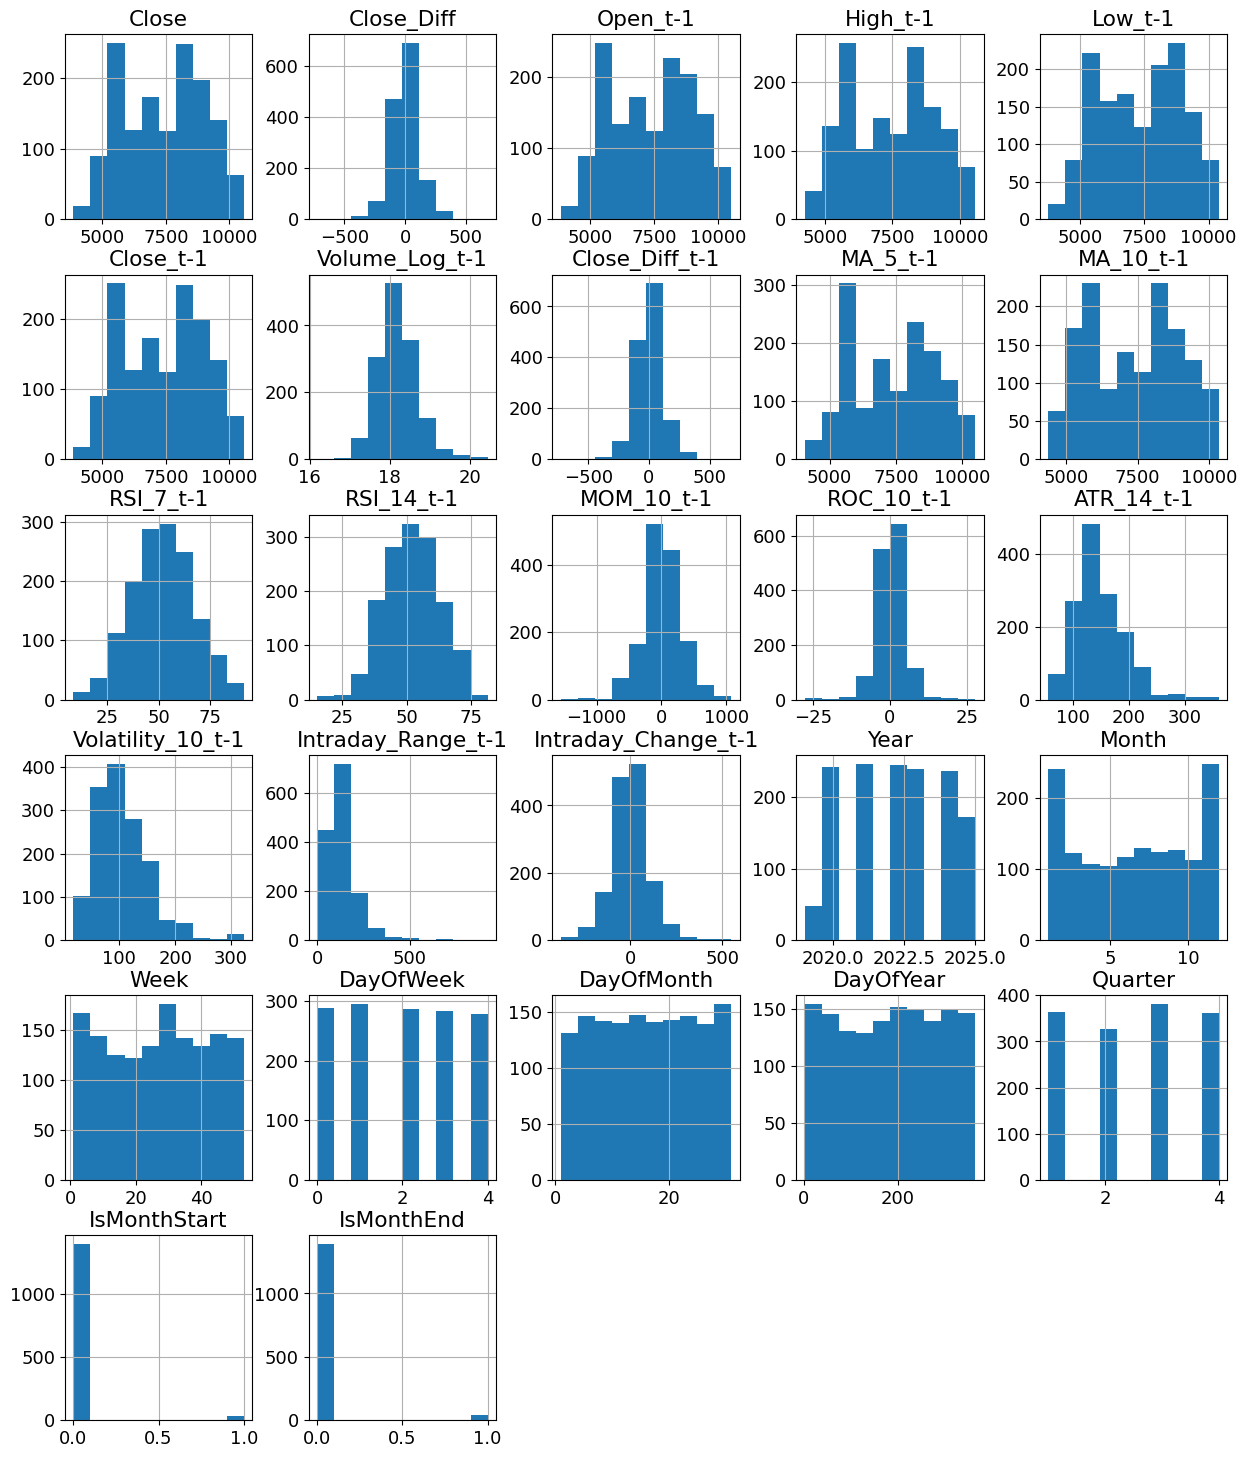

In [334]:
# Melihat Distribusi dari Setiap Variabel dalam Data Olahan
data_keseluruhan.hist(figsize=(15,18))

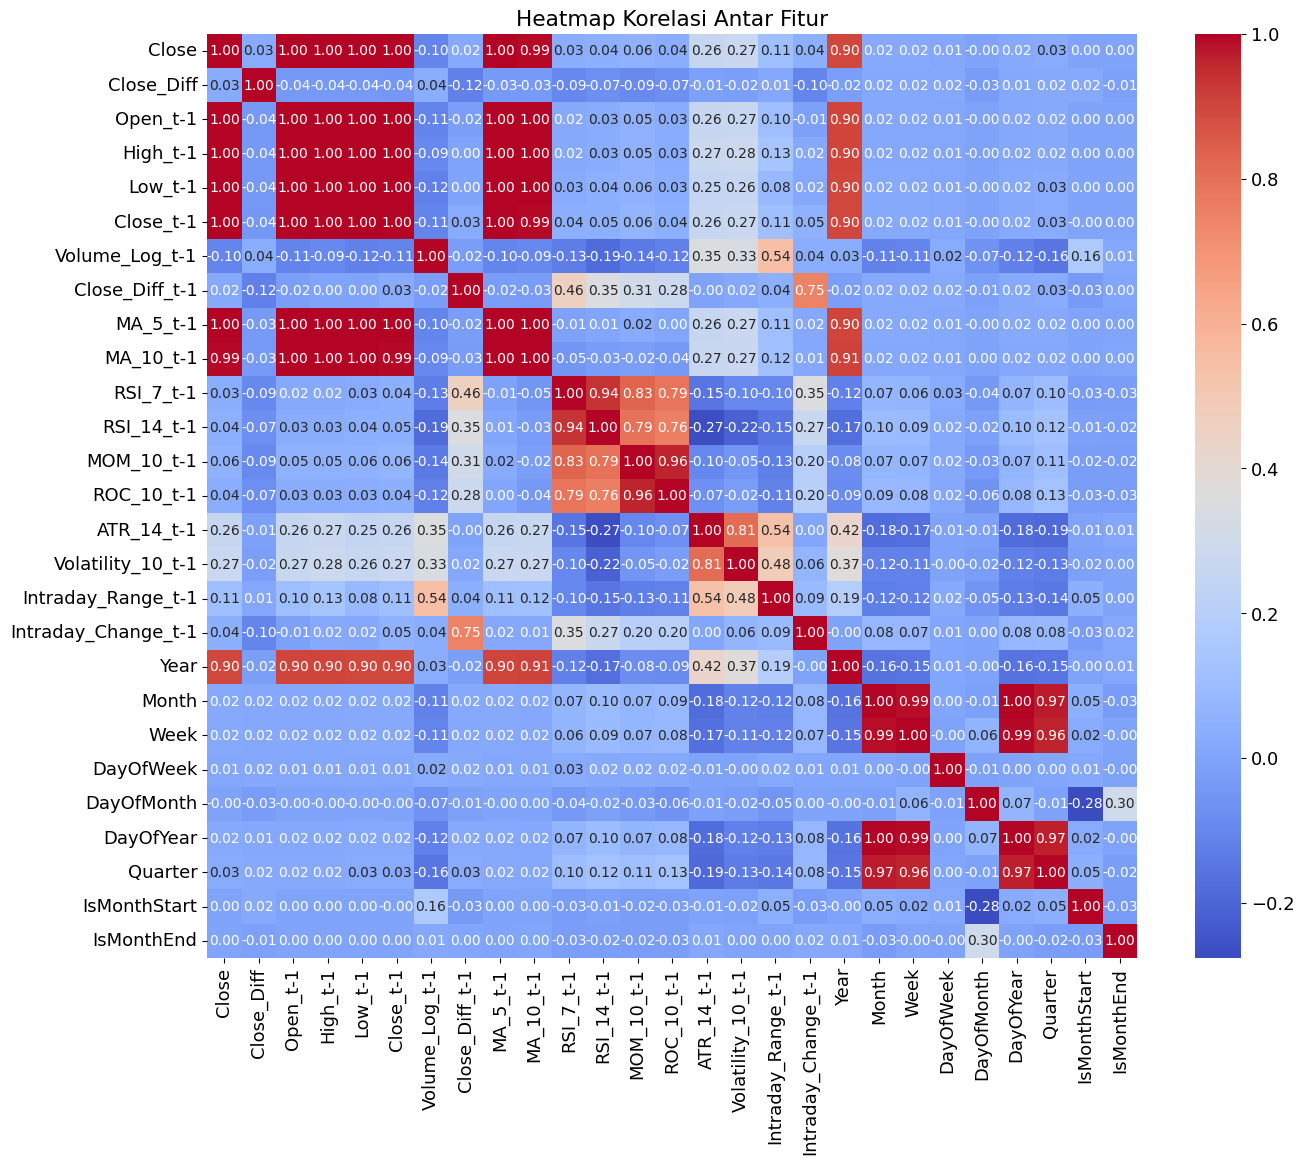

In [335]:
# Membuat Correlation Matrix dari Setiap Variabel
plt.figure(figsize=(15, 12))
correlation_matrix = data_keseluruhan.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

Train-Test Split Data

In [336]:
# Melakukan Features Selection, memilih variabel sebagai input dan output
features = [col for col in data_keseluruhan.columns if col not in ['Close_Diff', 'Close', 'Close_t-1']]
X = data_keseluruhan[features]
y = data_keseluruhan['Close_Diff']

# Menetapkan ukuran data latih sebesar 80% dari keseluruhan data olahan
train_size = int(len(data_keseluruhan) * 0.8)

# Menyesuaikan komposisi data latih dan data uji terhadap variabel input dan variabel ouptut
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

### Implementasi Model Random Forest tanpa Hyperparameter Tuning

Model Training and Testing

In [337]:
# Inisiasi Model Random Forest
rf = RandomForestRegressor(random_state=42,
                           n_jobs=-1)

# Melatih Model Random Forest dengan Data Latih
rf.fit(X_train, y_train)

# Model Random Forest melakuakan peramalan berdasarkan Data Uji
y_pred = rf.predict(X_test)

# Melihat akurasi model Random Forest tanpa Hyperparameter Tuning
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r_squared)

RMSE: 153.17624790867788
MAE: 118.91104507499455
MAPE: 1.4747301077154212e+16
R-squared: -0.09696951808512888


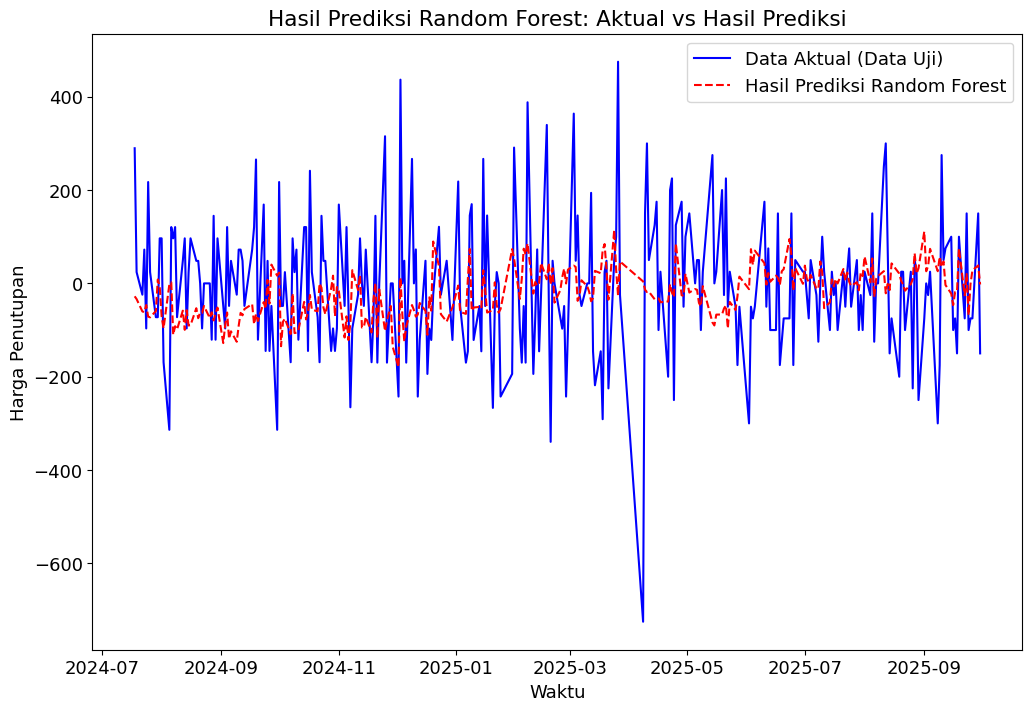

In [338]:
# Plotting hasil peramalan model Random Forest tanpa Hyperparameter Tuning
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Data Aktual (Data Uji)', color='blue')
plt.plot(y_test.index, y_pred, label='Hasil Prediksi Random Forest', color='red', linestyle='--')
plt.title('Hasil Prediksi Random Forest: Aktual vs Hasil Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

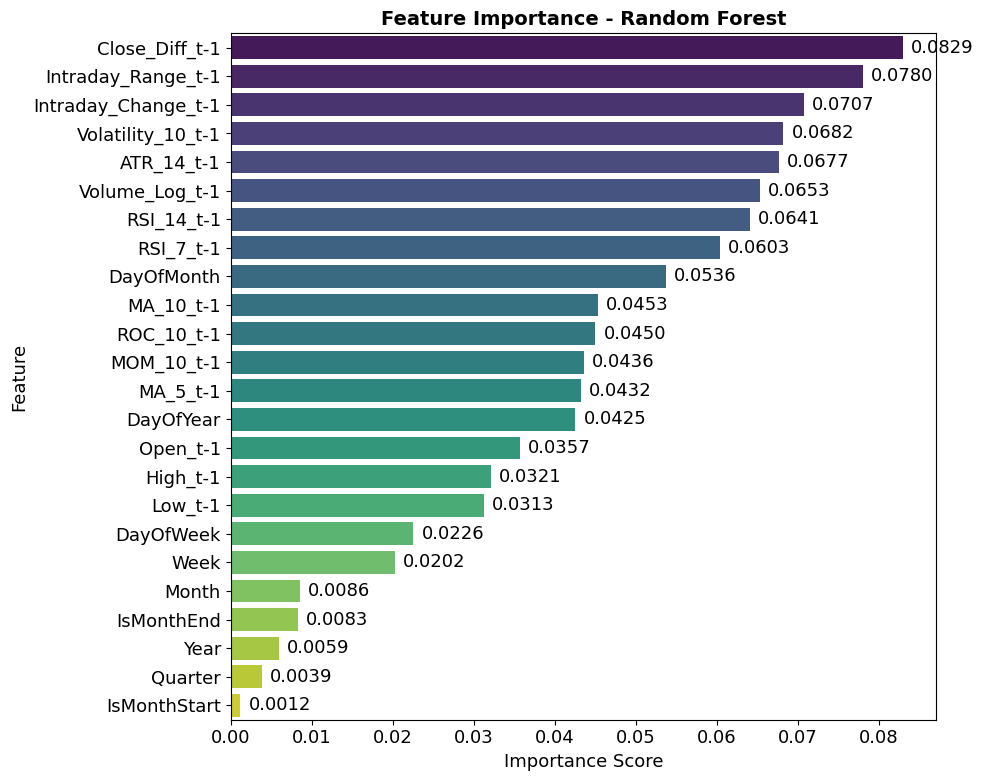

In [ ]:
# Melihat Feature Importances, tingkat kontribusi setiap variabel input dalam model Random Forest tanpa Hyperparameter Tuning
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# Visualisasi tingkat kontribusi setiap variabel input dalam model Random Forest tanpa Hyperparameter Tuning
plt.figure(figsize=(10, 10))

ax = sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index,
    palette="viridis"
)

for i, v in enumerate(importances_sorted.values):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')

plt.title("Feature Importance - Random Forest", fontsize=14, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Implementasi Model Random Forest dengan Hyperparameter Tuning Bayesian Optimization

Algoritma Bayesian Optimization

In [340]:
# Melakukan TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Definisikan Parameter Bounds (pbounds) untuk BayesianOptimization
pbounds = {
    'n_estimators': (200, 1000),         
    'max_depth': (5, 50),             
    'min_samples_leaf': (1, 15),       
    'min_samples_split': (2, 20),
    'max_features': (0.1, 1.0)
}

def rf_cv_score(n_estimators, max_depth, min_samples_leaf, max_features, min_samples_split):
    try:
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_leaf = int(min_samples_leaf)
        min_samples_split = int(min_samples_split)

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=tscv,
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1
        )

        return np.mean(scores)

    except Exception as e:
        print(f"Error dengan parameter: {e}")
        return -1e9 

optimizer = BayesianOptimization(
    f=rf_cv_score,  # Fungsi yang akan dioptimalkan
    pbounds=pbounds,  # Batasan parameter
    random_state=42,
    verbose=2  
)

optimizer.maximize(
    init_points=5,  
    n_iter=50) 

best_params = optimizer.max['params']

n_est_best = int(best_params['n_estimators'])
m_depth_best = int(best_params['max_depth'])
m_leaf_best = int(best_params['min_samples_leaf'])
m_split_best= int(best_params['min_samples_split'])
m_feat_best = best_params['max_features']

print(f"Hyperparameter terbaik: n_estimators={n_est_best}, max_depth={m_depth_best}, min_samples_leaf={m_leaf_best}, min_samples_split={m_split_best}, max_features='{m_feat_best}'")

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | max_fe... |
-------------------------------------------------------------------------------------
| 1         | -100.9329 | 499.63209 | 47.782143 | 11.247915 | 12.775852 | 0.2404167 |
| 2         | -101.2882 | 324.79561 | 7.6137625 | 13.126466 | 12.820070 | 0.7372653 |
| 3         | -101.2160 | 216.46759 | 48.645943 | 12.654196 | 5.8221039 | 0.2636424 |
| 4         | -101.5929 | 346.72360 | 18.690900 | 8.3465900 | 9.7750103 | 0.3621062 |
| 5         | -102.4406 | 689.48231 | 11.277223 | 5.0900250 | 8.5945131 | 0.5104629 |
| 6         | -100.3659 | 499.92727 | 47.365532 | 12.261074 | 13.297559 | 0.1       |
| 7         | -100.6779 | 501.00841 | 46.502499 | 13.026270 | 13.443162 | 0.2416256 |
| 8         | -100.4032 | 499.00132 | 47.648192 | 13.634553 | 14.388824 | 0.1       |
| 9         | -100.3924 | 498.59653 | 46.944361 | 14.169752 | 11.949277 | 0.1       |
| 10        | -100.3628 | 497.83352 | 45.099414 | 12.7

Model Random Forest dengan Hyperparameter Tuning
menggunakan Bayesian Optimization

In [341]:
best_rf_model = RandomForestRegressor(
    n_estimators=n_est_best,
    max_depth=m_depth_best,
    min_samples_leaf=m_leaf_best,
    min_samples_split=m_split_best,
    max_features=m_feat_best,
    random_state=42,
    n_jobs=-1
)

best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r_squared)

RMSE: 145.6993074734875
MAE: 112.08550146717404
MAPE: 7323772745565007.0
R-squared: 0.0075087638907886944


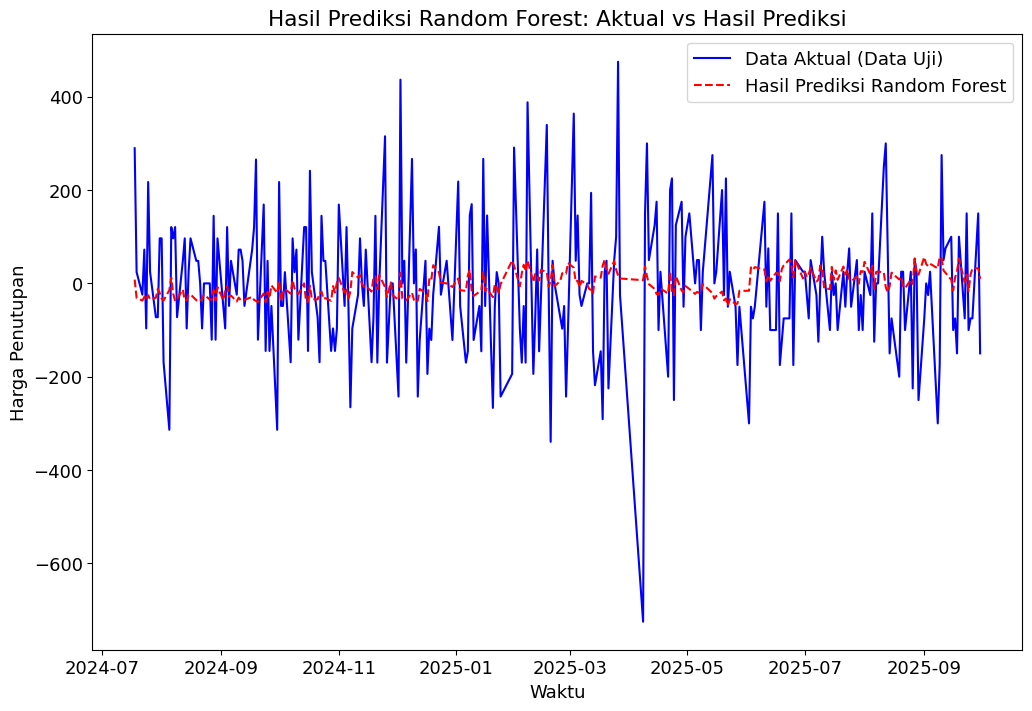

In [342]:
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Data Aktual (Data Uji)', color='blue')
plt.plot(y_test.index, y_pred, label='Hasil Prediksi Random Forest', color='red', linestyle='--')
plt.title('Hasil Prediksi Random Forest: Aktual vs Hasil Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

Feature Importance Model Bayesian Optimization-Random Forest

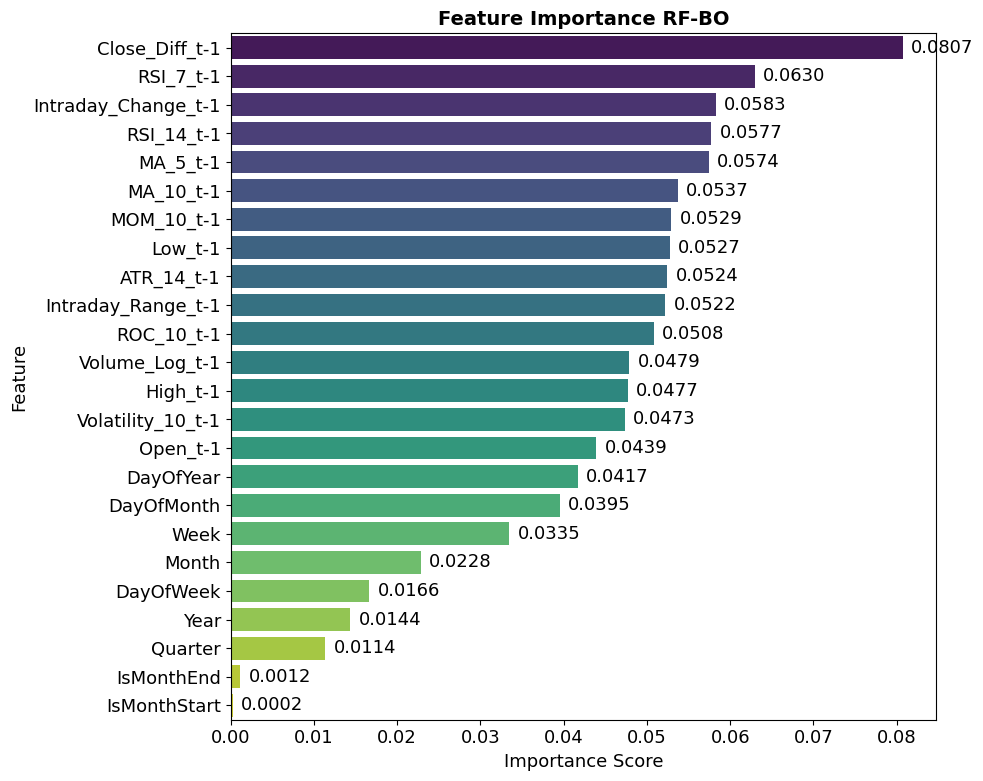

In [ ]:
importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)

importances_sorted = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 10))

ax = sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index,
    palette="viridis"
)

for i, v in enumerate(importances_sorted.values):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')

plt.title("Feature Importance RF-BO", fontsize=14, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Mengembalikan nilai data 'Close_Diff' ke dalam skala data awal


RMSE (Baru): 145.69930747348747
MAE (Baru): 112.08550146717404
MAPE (Baru): 0.012385055977503775
R-squared (Baru): 0.9632096179213181


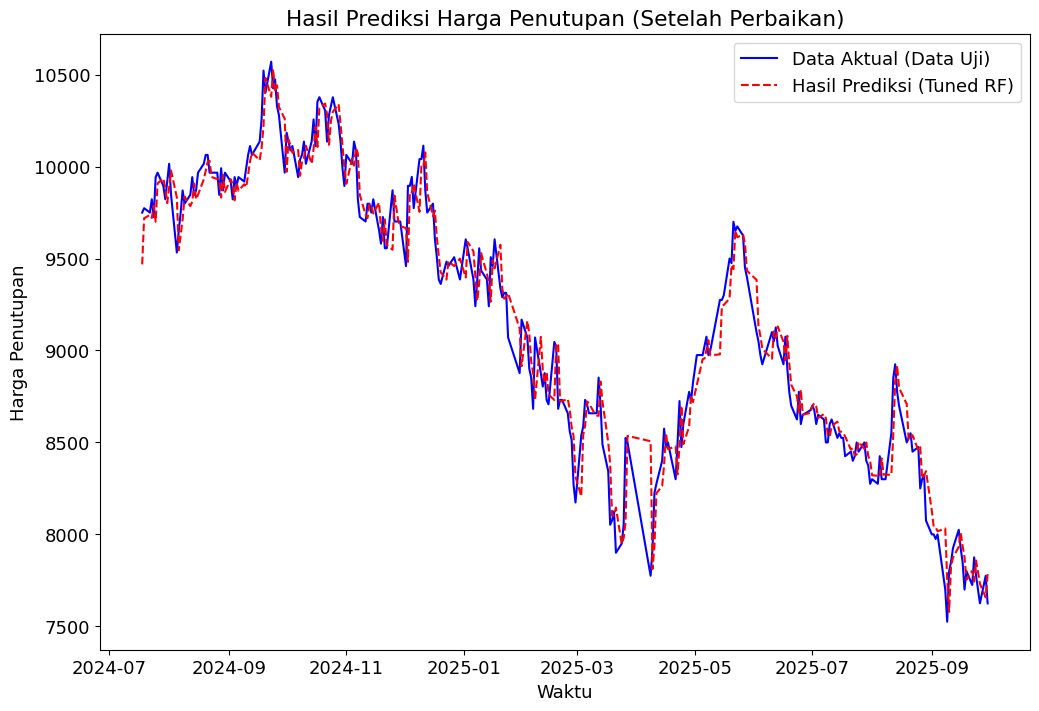

In [344]:
y_pred = best_rf_model.predict(X_test)
close_t_minus_1_test = data_keseluruhan.loc[X_test.index, 'Close_t-1']
close_actual_test = data_keseluruhan.loc[X_test.index, 'Close']
close_pred = close_t_minus_1_test + y_pred

hasil_df = pd.DataFrame({
    'Close_Actual': close_actual_test,
    'Close_Predicted': close_pred,
    'Pred_Close_Diff': y_pred
}, index=X_test.index)


rmse_new = root_mean_squared_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
mae_new = mean_absolute_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
mape_new = mean_absolute_percentage_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
r_squared_new = r2_score(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])

print('RMSE (Baru):', rmse_new)
print('MAE (Baru):', mae_new)
print('MAPE (Baru):', mape_new)
print('R-squared (Baru):', r_squared_new)

plt.figure(figsize=(12, 8))
plt.plot(hasil_df.index, hasil_df['Close_Actual'], label='Data Aktual (Data Uji)', color='blue')
plt.plot(hasil_df.index, hasil_df['Close_Predicted'], label='Hasil Prediksi (Tuned RF)', color='red', linestyle='--')
plt.title('Hasil Prediksi Harga Penutupan (Setelah Perbaikan)')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

In [345]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(hasil_df)

,Close_Actual,Close_Predicted,Pred_Close_Diff
Date,,,
2024-07-18,9749.879883,9468.382410,8.103113
2024-07-19,9774.013672,9718.856225,-31.023658
2024-07-22,9749.879883,9737.080243,-36.933429
2024-07-23,9822.280273,9720.859516,-29.020367
2024-07-24,9725.746094,9787.726724,-34.553549
2024-07-25,9942.946289,9700.478709,-25.267384
2024-07-26,9967.080078,9908.649603,-34.296686
2024-07-29,9894.679688,9936.237924,-30.842154
2024-07-30,9822.280273,9882.976829,-11.702858
